# Profiling ubersum with different plate sizes

In [13]:
from __future__ import absolute_import, division, print_function

import argparse
import timeit

import torch
from matplotlib import pyplot
from pyro.ops.contract import ubersum

%matplotlib inline
# torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [4]:
_CACHE = {}

def jit_ubersum(equation, *operands, **kwargs):

    key = equation, kwargs['batch_dims']
    if key not in _CACHE:

        def _ubersum(*operands):
            return ubersum(equation, *operands, **kwargs)

        fn = torch.jit.trace(_ubersum, operands, check_trace=False)
        _CACHE[key] = fn

    return _CACHE[key](*operands)

In [5]:
def time_ubersum(equation, *operands, **kwargs):
    iters = kwargs.pop('iters')
    jit_ubersum(equation, *operands, **kwargs)
    time = -timeit.default_timer()
    for i in range(iters):
        jit_ubersum(equation, *operands, **kwargs)
    time += timeit.default_timer()
    return time

In [9]:
args = type('Args', (), {})
args.equation = "a,abi,bcij,adj,deij->"
args.batch_dims = "ij"
args.dim_size = 32
args.max_plate_size = 32
args.iters = 100

In [11]:
equation = args.equation
batch_dims = args.batch_dims
inputs, outputs = equation.split('->')
inputs = inputs.split(',')

dim_size = args.dim_size
times = {}
for plate_size in reversed(range(1, 1 + args.max_plate_size)):
    operands = []
    for dims in inputs:
        shape = torch.Size([plate_size if d in batch_dims else dim_size
                            for d in dims])
        operands.append(torch.randn(shape))

    time = time_ubersum(equation, *operands, batch_dims=batch_dims, iters=args.iters)
    times[plate_size] = time

for plate_size, time in sorted(times.items()):
    print('{}\t{}'.format(plate_size, time))

1	0.0343878269196
2	0.044538974762
3	0.0503361225128
4	0.0610308647156
5	0.0828049182892
6	0.0876059532166
7	0.0889799594879
8	0.0967180728912
9	0.101272106171
10	0.111059904099
11	0.125076055527
12	0.156212091446
13	0.17559504509
14	0.188929080963
15	0.28804397583
16	0.280915021896
17	0.316980838776
18	0.37806892395
19	0.394499063492
20	0.39667391777
21	0.486795902252
22	0.529462099075
23	0.481663942337
24	0.441684007645
25	0.558567047119
26	0.604866027832
27	0.675321102142
28	0.64307808876
29	0.738641023636
30	0.790632009506
31	0.857040166855
32	0.748495817184


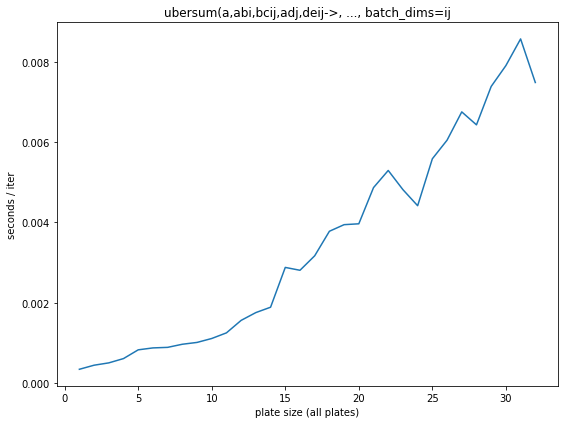

In [15]:
X = sorted(times.keys())
Y = [times[t] / args.iters for t in X]
pyplot.figure(figsize=(8,6)).patch.set_color('white')
pyplot.plot(X, Y)
pyplot.title('ubersum({}, ..., batch_dims={}'.format(args.equation, args.batch_dims))
pyplot.ylabel('seconds / iter')
pyplot.xlabel('plate size (all plates)')
pyplot.tight_layout()